In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.linalg as la
import scipy.special as sp
import scipy.misc as misc
import scipy.ndimage as ndimage
from scipy.optimize import minimize
import scipy.io as sio

import matplotlib.pyplot as plt

import spherepix.image as image
import spherepix.geometry as sgeom
import spherepix.pixelation as pixelation
import spherepix.camera as cam
import spherepix.blending as blending
from spherepix.plot import plot as splot

import spherepix.gpu.camera as gcam
import spherepix.gpu.pixelation as gpix


In [3]:
def mapOmnidirectionalImage(img, camGPU, pix):
    
    # GPU image
    gimg = gpix.PixelationFaceImage(img.shape)
    gimg.upload(img.astype(np.float32))

    imgList = list()

    # for each pixelation face
    for k in range(pix.faceCount()):

        etas = pix.faceCoordinates(k)
        gface = gpix.PixelationFace(etas)

        # create a face mapper for face k
        mapper = gcam.GPUFaceImageMapper(camGPU, gface, gimg)
        mapper.compute()
        
        # download the mapped image from GPU memory to CPU memory space
        imgMapped = mapper.getMappedImage().download()
        imgList.append(imgMapped)
    
    return imgList


# Pixelation load

In [4]:
pix = pixelation.loadPixelation('../pixelations/M1_1024/pix.json')
etas = pix.faceCoordinates(5)
etasDist = np.rad2deg(sgeom.distanceBetweenNeighbors(etas))
print('Angular distance in degrees etas patch (min, max): ({0}, {1})'.format(np.min(etasDist), np.max(etasDist)))

Angular distance in degrees etas patch (min, max): (0.0733397081494, 0.0952276289463)


# Omnidirectional camera model

The ommnidirectional camera model is calculated using the calibration toolbox of Scaramuzza et. al. (below). To render the images, we used Blender with the omnidirectional camera plugin available at https://github.com/uzh-rpg/rpg_blender_omni_camera

The ominidirectional camera parameters in Blender are:

```
a = [-1.318452e+02 0.000000e+00 1.913988e-03 -3.046731e-08 -4.328923e-10] 
Shift (pixels): X = 0.01, Y = 0.0
Affine parameters: c = 1.0, d = -0.000053, e = -0.000068
Radius = 0
```

The Matlab toolbox https://sites.google.com/site/scarabotix/ocamcalib-toolbox is used to compute the spherical coordinates of the camera and are stored in a .mat file to be loaded by Python to create an omnidirectional camera object.

### Note:

Any omnidirectional camera toolbox can be used with Spherepix (e.g. Schonbein et. al.). The only requirement is to be able to create a 2D grid that maps pixel coordinates (row, col) to unit sphere coordinates (x, y, z).

### References

```
@InProceedings{2006_Scaramuzza,
  Title                    = {A Toolbox for Easily Calibrating Omnidirectional Cameras},
  Author                   = {Scaramuzza, D. and Martinelli, A. and Siegwart, R.},
  Booktitle                = {Proc. IEEE/RSJ Int. Conf. Intell. Robots and Sys.},
  Year                     = {2006}
}

@InProceedings{2014_Schonbein,
  Title                    = {Calibrating and centering quasi-central catadioptric cameras},
  Author                   = {Sch{\"o}nbein, M. and Straus, T. and Geiger, A.},
  Booktitle                = {Proc. IEEE Conf. Robot. Autom.},
  Year                     = {2014}
}


```

In [ ]:
# This code is specific for the omnidirectional camera toolbox of Scaramuzza et. al.
# It is however possible to use any toolbox provided it can generate a 2D grid of
# unit sphere coordinates (x, y ,z) for each pixel location.

# read spherical coordinates from mat file
M = sio.loadmat('../cameras/omnidirectional/sphereCoordinates.mat')
camScoords = M['M'].astype(np.float32)
[X, Y, Z] = [np.copy(np.reshape(camScoords[n,:], (768, 1024))) for n in range(3)]
camScoords = np.concatenate([p[...,np.newaxis] for p in [X, Y, Z]], axis=2)

dist = np.rad2deg(sgeom.distanceBetweenNeighbors(camScoords))
ang = np.rad2deg(sgeom.angleBetweenNeighbors(camScoords))

print('Angular distance in degrees (min, max): ({0}, {1})'.format(np.min(dist), np.max(dist)))

Angular distance in degrees (min, max): (0.0584294982255, 0.434562236071)
[768, 1024]


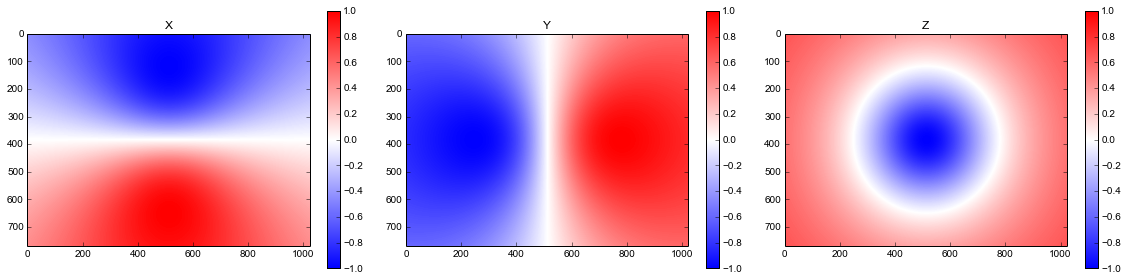

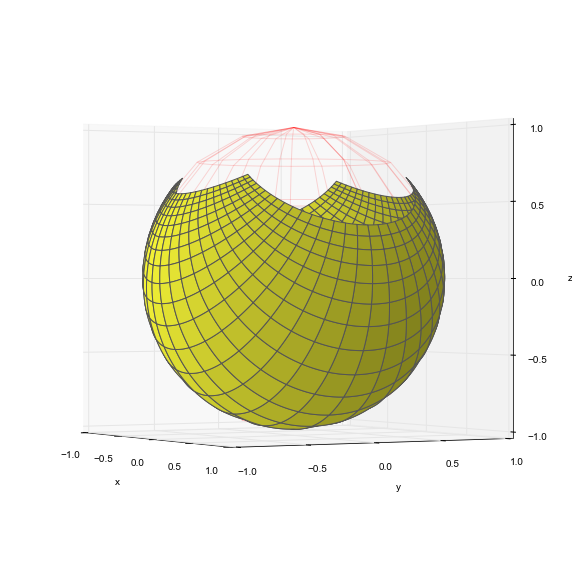

In [7]:


# Create an omnidirectional camera with the spherical coordinates.
camHost = cam.OmnidirectionalCamera(camScoords, False)
camGPU = gcam.GPUCamera(camHost)
print([camGPU.height, camGPU.width])

# plot the spherical coordinate grid
fig = plt.figure(figsize=(16,4)); fig.set_tight_layout(True)
plt.subplot2grid((1,3), (0,0)); plt.imshow(X, cmap='bwr', vmin=-1, vmax=1); plt.colorbar(); plt.title('X')
plt.subplot2grid((1,3), (0,1)); plt.imshow(Y, cmap='bwr', vmin=-1, vmax=1); plt.colorbar(); plt.title('Y')
plt.subplot2grid((1,3), (0,2)); plt.imshow(Z, cmap='bwr', vmin=-1, vmax=1); plt.colorbar(); plt.title('Z')
plt.show()


# 3D view
fig, ax = splot.createFigure(elev=0, azim=-30)
splot.addSphere(ax)
splot.plotSurface(ax, camScoords, stride=32, color='#fffe39', edgecolor='#555555')
plt.show()

# Image Mapping

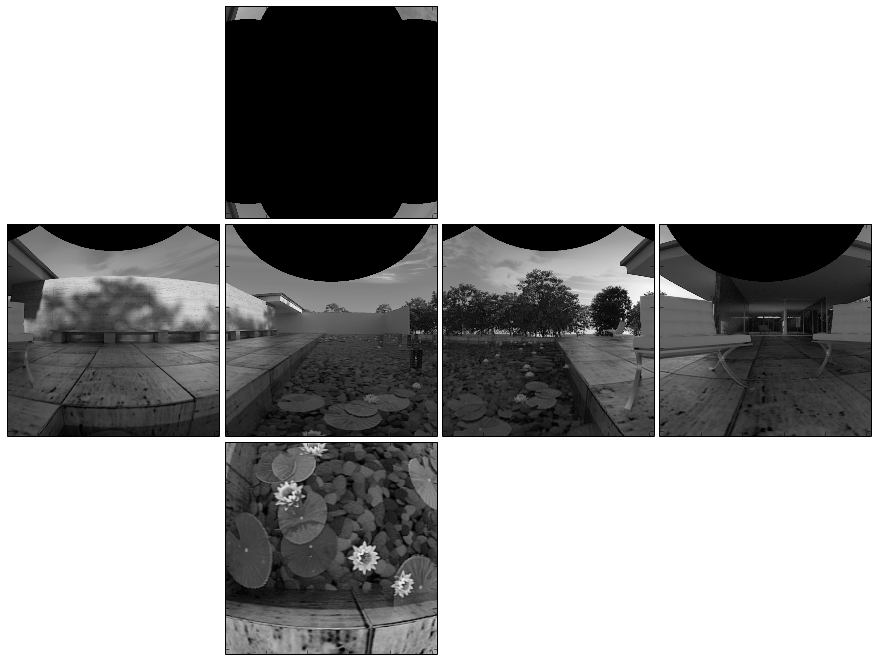

In [6]:
img = misc.imread('../images/pabellon_barcelona/omnidirectional_0.jpg', flatten=True).astype(np.float32)
imgMapped = mapOmnidirectionalImage(img, camGPU, pix)

fig = splot.plotPixelationImage(imgMapped, scale=0.25, cmap='gray', vmin=0, vmax=255)
plt.show()
